# Wine Quality Analysis

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler, LabelEncoder
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.metrics import accuracy_score
import statsmodels.api as sm
import functions as fn
from itertools import combinations_with_replacement, combinations
import warnings
from scipy import stats

sns.set_style("darkgrid")
warnings.filterwarnings('ignore')

This Jupyter Notebook contains analysis on the red variants of the Portuguese "Vinho Verde" wine. The dataset contains several physicochemical The purpose of the aforementioned analysis is two-fold:Goals:
1. Figure out what physicochemical variables exceptional variants (with a quality > 6) of the Vinho Verde wine have as opposed to non-exceptional variants?
2. Create a statistical model that would be able to explain how the physicochemical variables affect the quality of the "Vinho Verde" wine to a high degree.

### Table of Contents

1. Data Input and Preparation
2. Data Analysis & Structural Analysis
2. Modelling
3. Conclusions


## Data Input and Preparation

In [2]:
wines_data = pd.read_csv('winequality-red.csv')
wines_data.head()
print(wines_data.columns)

Index(['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar',
       'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density',
       'pH', 'sulphates', 'alcohol', 'quality'],
      dtype='object')


The dataset seems to have 11 `physicochemical` variables (`fixed acidity`, `volatile acidity`, `citric acid`, `residual sugar`, `chlorides`, `free sulfur dioxide`, `total sulfur dioxide`, `density`, `pH`, `sulphates`, `alcohol`, `quality`) and 1 sensory metric of good the wine variants are (`quality`).

In [3]:
wines_data.isna().sum()

fixed acidity           0
volatile acidity        0
citric acid             0
residual sugar          0
chlorides               0
free sulfur dioxide     0
total sulfur dioxide    0
density                 0
pH                      0
sulphates               0
alcohol                 0
quality                 0
dtype: int64

The dataset also seems to not have any missing data values, which is great! Now let's fix up the columns so that they would be easier to work with in the modelling process:

In [4]:
wines_data.rename(columns= fn.reformating_columns(wines_data), inplace=True)
original_columns = wines_data.columns
wines_data.describe()

,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,pH,sulphates,alcohol,quality
count,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000
mean,8.319637,0.527821,0.270976,2.538806,0.087467,15.874922,46.467792,0.996747,3.311113,0.658149,10.422983,5.636023
std,1.741096,0.179060,0.194801,1.409928,0.047065,10.460157,32.895324,0.001887,0.154386,0.169507,1.065668,0.807569
min,4.600000,0.120000,0.000000,0.900000,0.012000,1.000000,6.000000,0.990070,2.740000,0.330000,8.400000,3.000000
25%,7.100000,0.390000,0.090000,1.900000,0.070000,7.000000,22.000000,0.995600,3.210000,0.550000,9.500000,5.000000
50%,7.900000,0.520000,0.260000,2.200000,0.079000,14.000000,38.000000,0.996750,3.310000,0.620000,10.200000,6.000000
75%,9.200000,0.640000,0.420000,2.600000,0.090000,21.000000,62.000000,0.997835,3.400000,0.730000,11.100000,6.000000
max,15.900000,1.580000,1.000000,15.500000,0.611000,72.000000,289.000000,1.003690,4.010000,2.000000,14.900000,8.000000


Taking a look at the main distribution metrics for each category it is clear that we might be have an interpretability issue as all values in the dataset seem to be on a different scale (e.g.: pH seems to range from `~2.7` to `~4`, whereas `citric_acid`, which typically is found in small quantities and should enhance the freshness of the flavor, ranges from `~0` to `~1`; `fixed_acidity` on the other hand can range from `~4` to as high as `~16`). This just displays how each physicochemical variable has its own scale and in order for us to be able to use statistical modelling on the dataset, we would need to scale the features so that we could correctly interpret the coefficients that we get.

Since according to the goals that we have created for ourselves require having the `quality` metric as the independent variable, let's look at the distributions of both the `physicochemical` and the `quality` metrics.

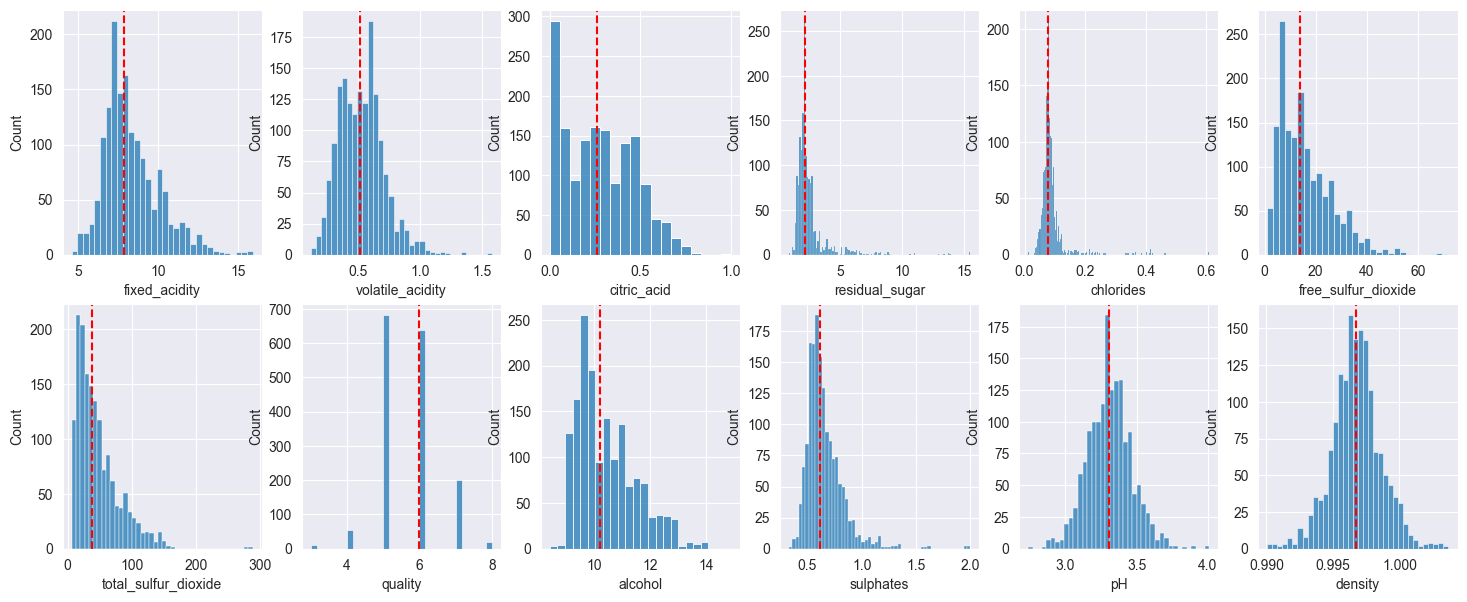

In [5]:
numeric_variables = wines_data.select_dtypes(include=[np.number]).columns

fig, ax = plt.subplots(2, 6, figsize = (18, 7))

for i, col in enumerate(numeric_variables):
    try:
        sns.histplot(wines_data[col], ax = ax[0][i]);
        ax[0][i].axvline(x=wines_data[col].median(), color='red', linestyle='--')
    except:
        sns.histplot(wines_data[col], ax = ax[1][6 - i]);
        ax[1][6 - i].axvline(x=wines_data[col].median(), color='red', linestyle='--')


# Test for normality:
# stats.shapiro

First things first, it is already clear that not all variables are distributed normally - e.g. `citric_acid` and `free_sulfur_dioxide` seem to be heavily skewed to the right. This means that these metrics especially might be more difficult to use as model parameters because of them having high outliers or potential heteroskedasticiy (inconsistent variance of errors across values of independent variables). We will deal with that later

Additionally, we can also see that the values do in fact have very different scales, which can be fixed with standardization. 

But before we do that, let's set up the exceptional_quality boolean variable whic we loosely define as when the quality > 6 

In [6]:
wines_data['exceptional_quality'] = wines_data['quality'] > 6
print("Exceptional Quality ")
wines_data['exceptional_quality'].value_counts()

Exceptional Quality 


False    1382
True      217
Name: exceptional_quality, dtype: int64

There seems to be 217 wines that fit the exceptional quality criteria - not too bad. Although, creating a classification model on an inbalanced dataset like this would be problematic. Perhaps we can forego the statistical modelling for our first goal - analysis of what makes a wine exceptional in quality, for a more rudimentary analysis. Also, for further analysis we are going to outline a potential independent variable space for our models, comprised of the physicochemical variables in the dataset.

In [7]:
possible_variable_space = wines_data.columns
possible_variable_space = possible_variable_space.drop(['quality', 'exceptional_quality'])
print(possible_variable_space)

Index(['fixed_acidity', 'volatile_acidity', 'citric_acid', 'residual_sugar',
       'chlorides', 'free_sulfur_dioxide', 'total_sulfur_dioxide', 'density',
       'pH', 'sulphates', 'alcohol'],
      dtype='object')


## Data Analysis & Structural Analysis

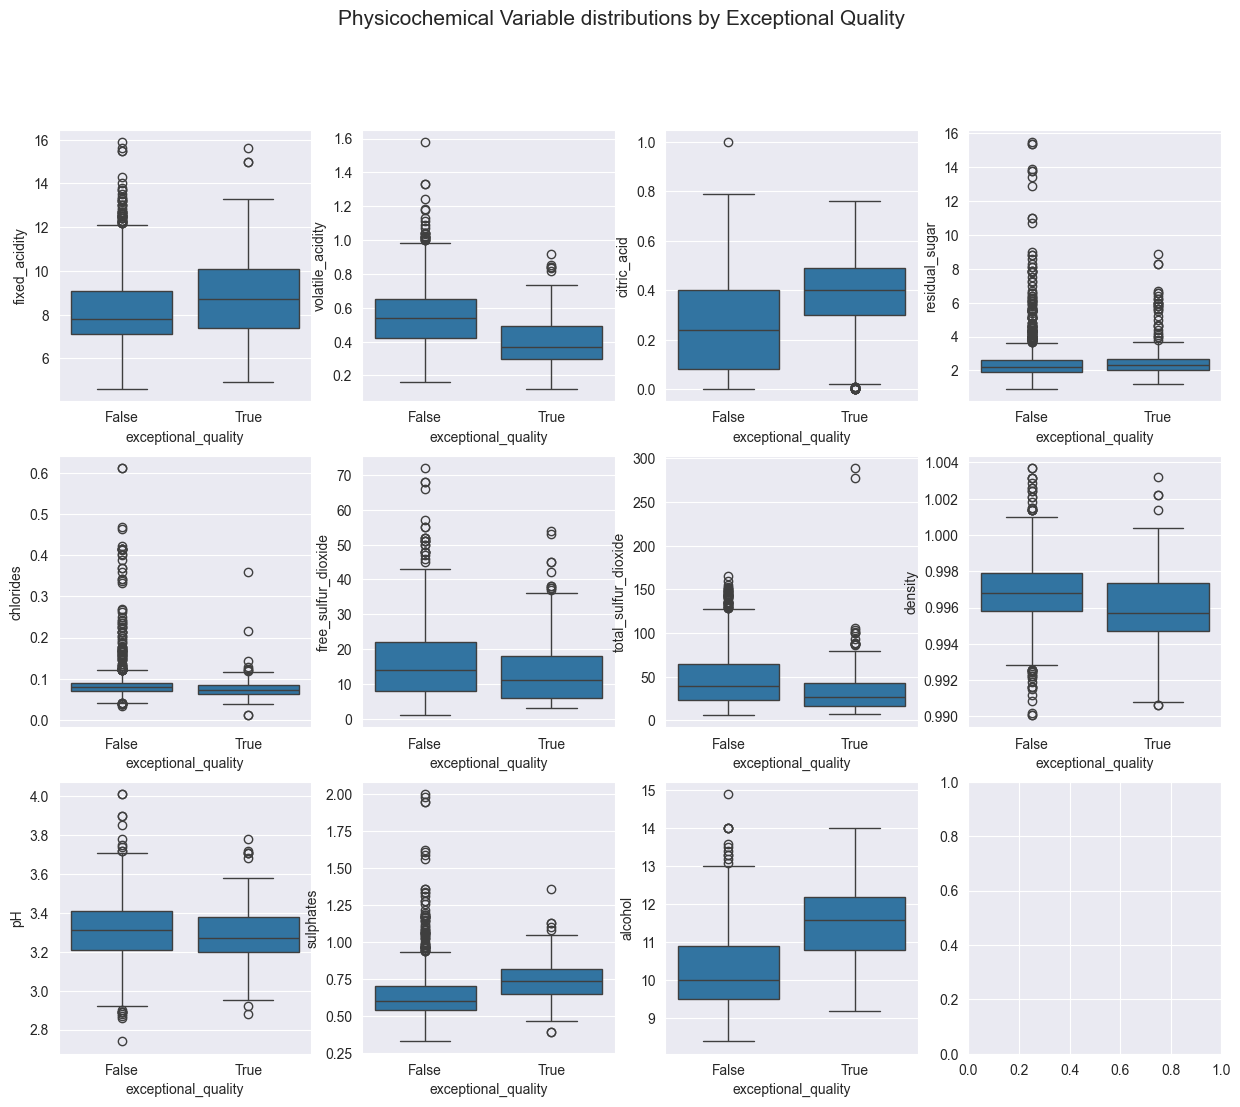

In [8]:
fig, ax = plt.subplots(3, 4, figsize = (15, 12))

for i, col in enumerate(possible_variable_space):
    if i < 4:
        axi = ax[0][i]
    elif i < 8:
        axi = ax[1][i - 4]
    else:
        axi = ax[2][i - 8]
    sns.boxplot(x = 'exceptional_quality', y = col, data=wines_data, ax = axi)


plt.suptitle(f'Physicochemical Variable distributions by Exceptional Quality', fontsize = 15);

This is quite interesting - if we just take a look at the means of the physicochemical variables, we can already gather that based on our sample alone:
1. Exceptional Quality wines seem to have higher `fixed_acidity`, significantly lower `volatile_acidity`, higher `citric_acid`, higher `sulphate` concentration & more `alcohol`. This means that if we take a look at only the means, we can glean that exceptional "Vinho Verde" wines have more acids taht don't evaporate readily, have lower `acetic acid` values (which means less vinegar taste), are more fresh in taste, higher sulphates and are more alcoholic. 
2. Exceptional Wines seem to also have less variance in each of the physicochemical variable distributions.

What if ran some t-tests to back the claims we made in the first point?

In [9]:
hypotheses_to_review = {'fixed_acidity' : 'larger',
                     'volatile_acidity' : 'smaller',
                     'citric_acid' : 'larger',
                     'sulphates' : 'larger',
                     'alcohol' : 'larger'}

exceptional_quality = wines_data[wines_data['exceptional_quality'] == True]
not_exceptional_quality = wines_data[wines_data['exceptional_quality'] == False]

fn.run_inferential_analysis_on_means(exceptional_quality, not_exceptional_quality, hypotheses_to_review)

Hypothesis: fixed_acidity mean for exceptional quality wines is larger
P-value: 7.374344191692198e-07
Verdict: Statistically True
Hypothesis: volatile_acidity mean for exceptional quality wines is smaller
P-value: 1.4789316904676025e-28
Verdict: Statistically True
Hypothesis: citric_acid mean for exceptional quality wines is larger
P-value: 1.967389868992378e-18
Verdict: Statistically True
Hypothesis: sulphates mean for exceptional quality wines is larger
P-value: 4.081459385818517e-16
Verdict: Statistically True
Hypothesis: alcohol mean for exceptional quality wines is larger
P-value: 3.0083871131621293e-65
Verdict: Statistically True


Great! All of our claims are statistically significant! Now let's take a look a the other variables and how they are distributed in comparison to one another. Perhaps there are some relationships that seem to be of interest to us. Additionally, we will standardize the physicochemical features so as to limit the effect of different scales of features to our model-building process.

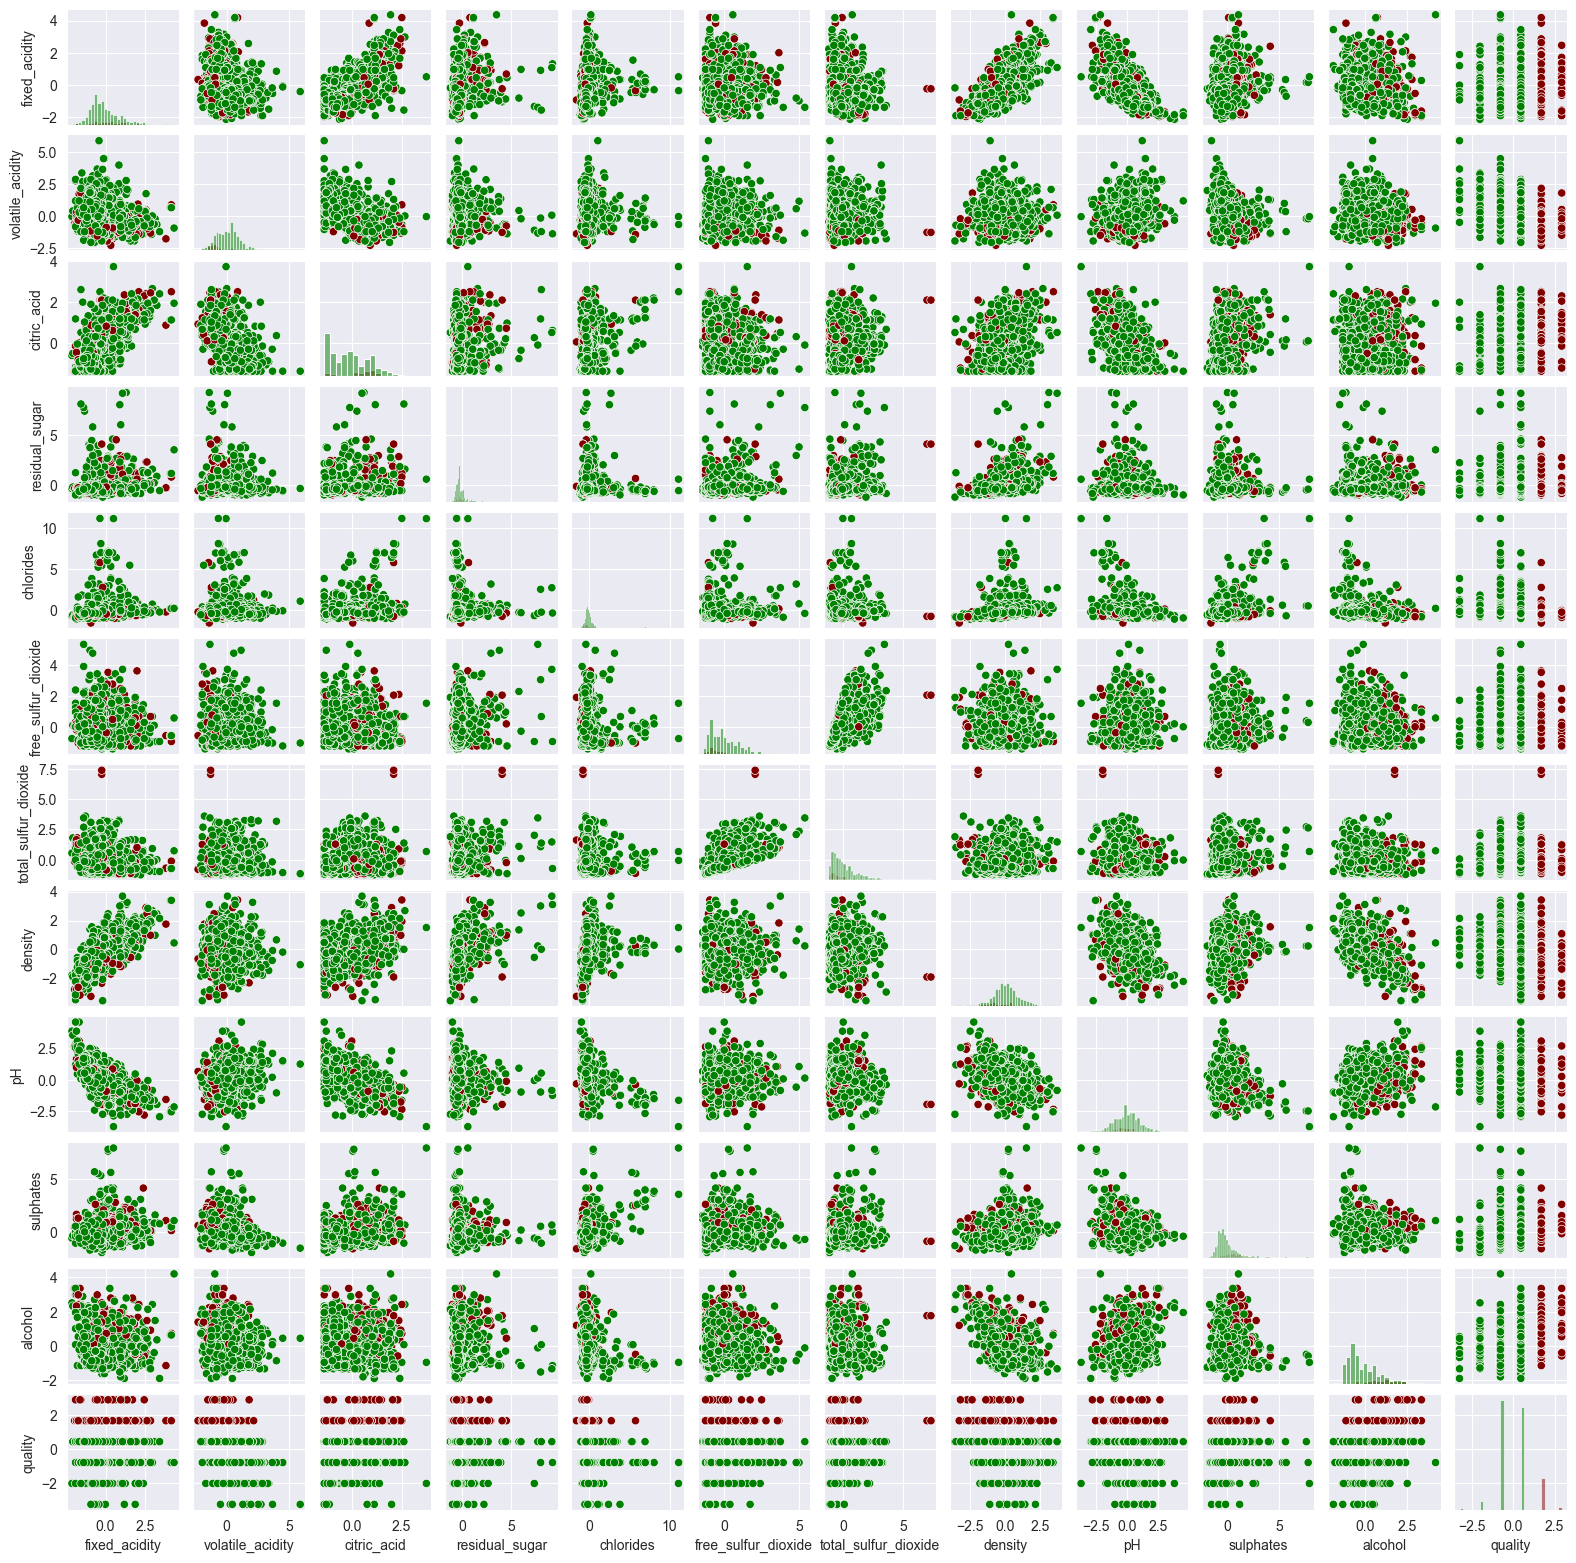

In [10]:
scaler = StandardScaler()
scaler.fit(wines_data)
wines_data_scaled = pd.DataFrame(scaler.transform(wines_data), columns=wines_data.columns)
wines_data = wines_data_scaled

g = sns.PairGrid(wines_data, hue = 'exceptional_quality', palette= ['green', 'maroon'])
g.map_diag(sns.histplot)
g.map_offdiag(sns.scatterplot);
# plt.savefig("chart.png")
plt.subplots_adjust(top=1.5, bottom=1, left = 2.5, right = 3)

There are definitely some interesting findings to be had from this:

1. `fixed_acidity` seems to be strongly positively correlated with `citric_acid` & `density` & negatively with `pH`, which very much makes sense - pH is the acidity metric that has a higher value the more a substance is acidic. And there is a high chance that `citric_acid` is a part of the `fixed_acidity` metric.
2. `citric_acid` is somewhat correlated with `sulphates`.
3. `residual_sugar`, `chlorides` and `total_sulfur_dioxide` seems to have a lot of outliers with values that far exceed their means, but generally seems to be independent from the other physicochemical features.
4. `total` and `free` sulfur dioxide measures seem to be positively correlated, which makes sense.
5. `density` seems to be negatively correlated against `alcohol`, which is surprising.

Generally, from this analysis it seems as though the potential independent variables in the models that we will build are not correlated with each other. That means that we shouldn't have issues with multicollinearity. although, just in case let's check out the correlation matrix and calculate the Variance Inflation Factor for each of the independent variables.

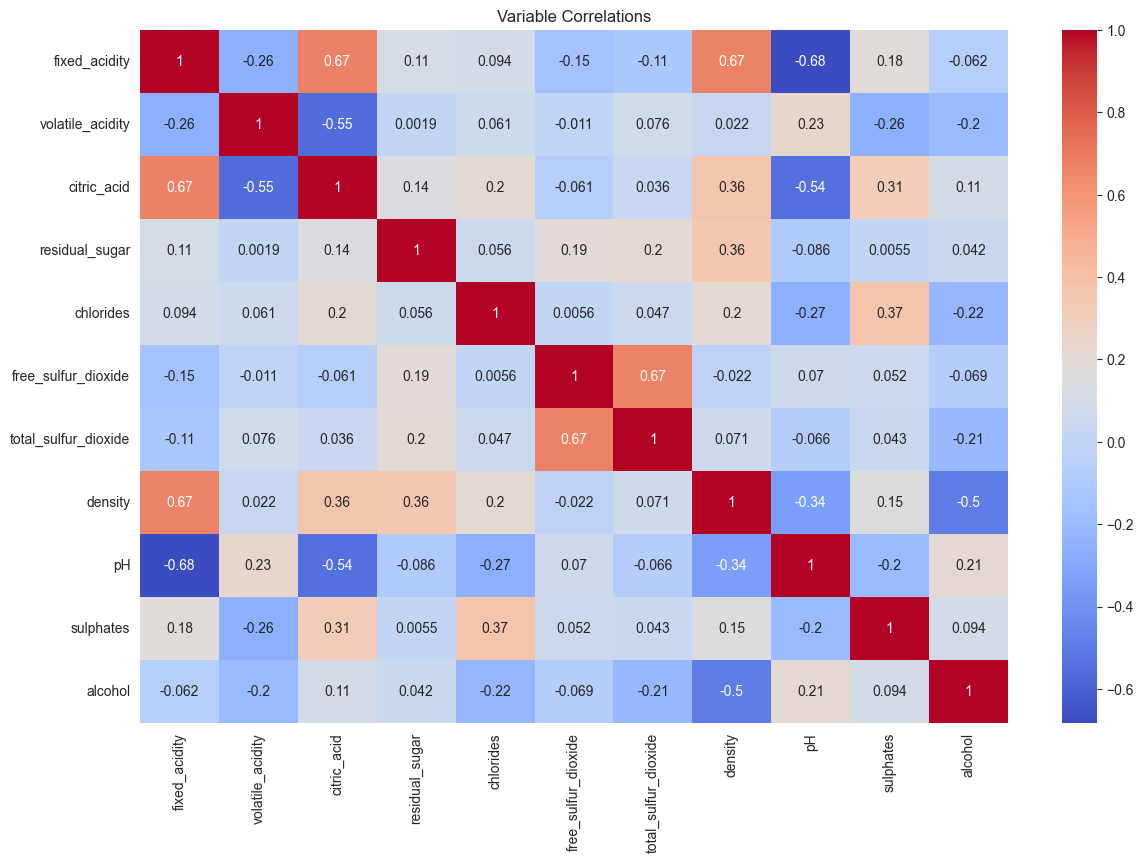

In [11]:
correlation_matrix = wines_data[possible_variable_space].corr()
plt.figure(figsize = (14, 9))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm")
plt.title('Variable Correlations');

The correlations `citric acid - fixed acidity`, `citric acid - volatile acidity`, `density - fixed acidity` & `pH - fixed acidity` do seem to be offly high. Let's look at the strength of the relationship between independent variables using the Variance Inflation Factor:

In [12]:
vif = [(val, variance_inflation_factor(wines_data[possible_variable_space].values, i))
       for val, i in zip(possible_variable_space, range(wines_data[possible_variable_space].shape[1]))]
print("Variance inflation factors for each feature in the potential independent variable space:")
vif

Variance inflation factors for each feature in the potential independent variable space:


[('fixed_acidity', 7.7675115657077765),
 ('volatile_acidity', 1.7893896822287891),
 ('citric_acid', 3.128022124356085),
 ('residual_sugar', 1.7025879081509248),
 ('chlorides', 1.481932329802808),
 ('free_sulfur_dioxide', 1.963019141481087),
 ('total_sulfur_dioxide', 2.1868127885900877),
 ('density', 6.343760185861592),
 ('pH', 3.3297316235826973),
 ('sulphates', 1.429433749389566),
 ('alcohol', 3.031159819884125)]

This does seem to suggest that `fixed acidity` & `density` are quite heavily linearly related with the other features as their VIF > 5. Thus, we will remove them from the potential variables space for the models we are to create.

In [13]:
possible_variable_space = possible_variable_space.drop(['fixed_acidity', 'density'])

Lastly, before we start the modelling section of the analysis, let's try and encode the Quality metric for both regression and classification modelling efforts.

In [14]:
encoder = LabelEncoder()

labels = wines_data['quality'].sort_values(ascending=True).unique()

wines_data['quality'] = encoder.fit_transform(wines_data['quality'].sort_values(ascending=True))
print(f"Labels: {wines_data.quality.unique()}")

column_changes = {0 : 4,
                  1 : 5,
                  2 : 6,
                  3 : 7,
                  4 : 8}

Labels: [0 1 2 3 4 5]


## Modelling

To begin, there is merit in using both regression and classification models in order to extract the best model to explain what physicochemical features create the most high quality wine. And yes, "explain", the purpose of the statistical models that we create will be for understanding the relationships between the physicochemical features and the quality of a wine rather than building the most accurate/efficient model.

We will start off by modelling the quality metric with a simple linear regression against one independent variable at a time. We also add the Polynomial version of the analysis.

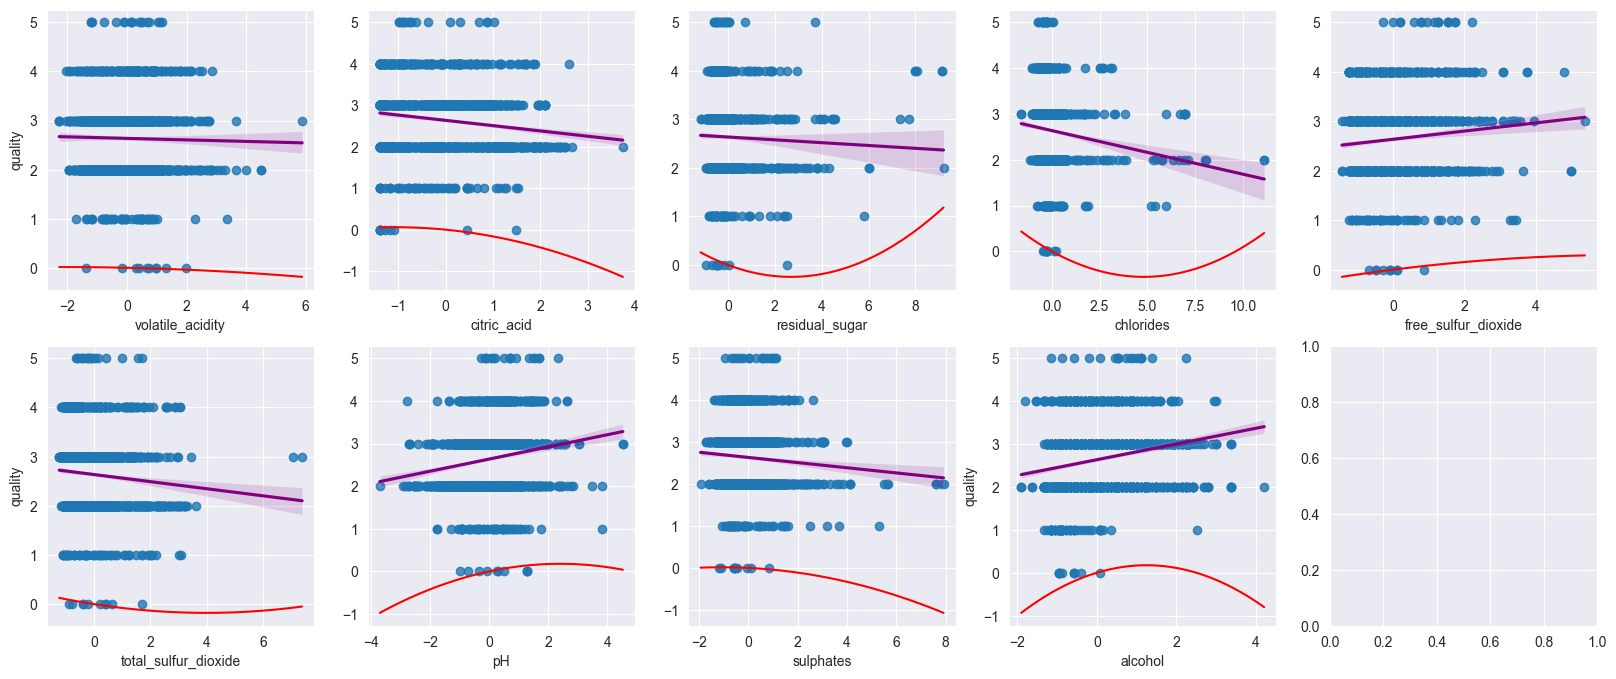

In [15]:
fig, ax = plt.subplots(2, 5, figsize = (20, 8))

for i, col in enumerate(possible_variable_space):
    # 3 // 5 --> row
    # 3 % 5 --> column

    x, y = wines_data[col], wines_data['quality']

    x_poly = np.vander(x.to_numpy(), 3)

    model = LinearRegression().fit(x_poly, y)

    x_line = np.linspace(min(wines_data[col]), max(wines_data[col]), 100)
    x_vandered = np.vander(x_line, 3)

    coefficients = model.coef_

    y_line = [coefficients[0]*xv[0] + coefficients[1]*xv[1] + coefficients[2]*xv[2] for xv in x_vandered] # --> could use numpy 

    if i < 5:
        sns.regplot(data = wines_data, x = col, y = 'quality', ax = ax[0][i], line_kws= {'color' : 'purple'});
        ax[0][i].plot(x_line, y_line, color="red", label=f"Polyfit (degree=2)")  # Adjust line color and label
        if i != 0:
            ax[0][i].set_ylabel('')
    else:
        sns.regplot(data = wines_data, x = col, y = 'quality', ax = ax[1][i - 5], line_kws= {'color' : 'purple'});
        ax[1][i - 5].plot(x_line, y_line, color="red", label=f"Polyfit (degree=2)")  # Adjust line color and label
        if i != 5:
            ax[1][4 - i].set_ylabel('')

All in all, they seem pretty bad in specifically measuring what the values would be. What if we tried adding more complexity to our model by creating a multinomial regression?

Due to the fact that there might be loadsof combinations of independent variables each comprising a separate model, we will model each possible combination of physicochemical variables in a Simple Linear Regression. However, due to the fact that the priority of this modeling exercise is to understand the relationships between the `Quality` metric and the physicochemical features to the best extent, priority for the best models will best firt by the `AIC` (a metric which penalises models that have high amounts of independent variables), by `Log-Likelihood` (the probability of observing the data given the parameters of the model) and then by `Adjusted R-squared`. 

But first, let's pull out all possible variants of multinomial linear models:

In [16]:
all_choices = fn.parameter_choice(possible_variable_space)

Now, we can create each model, we also use only `80%` of the entire dataset as a training data set. This is in order for us to be able to test the coefficients that we get from the model on the rest `20%` of the dataset. We also save all models that we create with the combinations of physicochemical variables by adding the `Adjusted_Rsquared`, `AIC`, `BIC`, `Log-Likelihood` & `MSE` of each model to the `all_linear_models` dataset. This is so that we could compare the performance of each model created.

In [17]:
all_linear_models = pd.DataFrame()

for variable_choice in all_choices:
    for i, variables in enumerate(variable_choice):
        if i > 0:
            train, test = fn.setting_train_test_split(wines_data)
            model, test_x, test_y = fn.model_set_up([*variables], 'quality', train, test)
            fn.calculate_metrics(model, [*variables], all_linear_models, logistic=False, test_x = test_x, test_y = test_y)

In [18]:
all_linear_models.sort_values(by = ['BIC', 'Log-Likelihood', 'Adjusted_RSquared'],
                              ascending = [True, False, False],
                              inplace = True)

best_linear_model = all_linear_models.iloc[0]
best_linear_model_model = best_linear_model['Model']
best_linear_model_ind_variables = best_linear_model['Ind_Variables'].split(',')
best_linear_model_adjusted_rsquared = best_linear_model['Adjusted_RSquared']

all_linear_models.iloc[:5]

,Ind_Variables,Adjusted_RSquared,AIC,BIC,Model,Log-Likelihood,MSE
"citric_acid,free_sulfur_dioxide,total_sulfur_dioxide,alcohol","citric_acid,free_sulfur_dioxide,total_sulfur_d...",0.128838,2920.988457,2946.757627,<statsmodels.regression.linear_model.OLS objec...,-1455.494229,27.617753
"volatile_acidity,citric_acid,free_sulfur_dioxide,total_sulfur_dioxide,alcohol","volatile_acidity,citric_acid,free_sulfur_dioxi...",0.130699,2919.249563,2950.172566,<statsmodels.regression.linear_model.OLS objec...,-1453.624782,22.519912
"citric_acid,free_sulfur_dioxide,total_sulfur_dioxide,sulphates,alcohol","citric_acid,free_sulfur_dioxide,total_sulfur_d...",0.129970,2920.321396,2951.244399,<statsmodels.regression.linear_model.OLS objec...,-1454.160698,22.398001
"citric_acid,residual_sugar,free_sulfur_dioxide,total_sulfur_dioxide,alcohol","citric_acid,residual_sugar,free_sulfur_dioxide...",0.128591,2922.347712,2953.270715,<statsmodels.regression.linear_model.OLS objec...,-1455.173856,22.167246
"citric_acid,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,alcohol","citric_acid,chlorides,free_sulfur_dioxide,tota...",0.128275,2922.810405,2953.733408,<statsmodels.regression.linear_model.OLS objec...,-1455.405202,22.114504


It seems that the best model according to the metrics we have chosen seems to be one that has `citric_acid`,`free_sulfur_dioxide`, `total_sulfur_dioxide` and `alcohol`. Although the explanatory power seems to be very low (`0.128838`) and the log-likelihood is very low too. This is not a great model. Let's look at whether the residuals were atleast normally distributed.

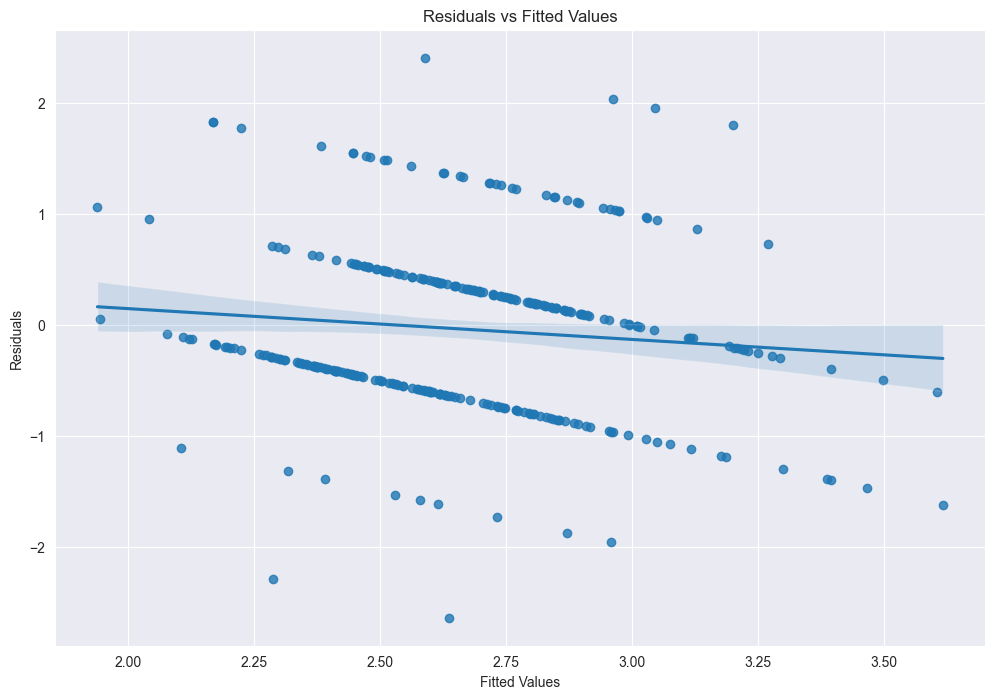

In [19]:
model, test_x, test_y = fn.model_set_up(best_linear_model['Ind_Variables'].split(','), 'quality', train, test)
test_x = sm.add_constant(test_x)
y_fitted = model.fit().predict(test_x)

# Get residuals
y_resid = test_y - y_fitted

linear_model_accuracy = sum([y_fit == ty for y_fit, ty in zip(round(y_fitted, 0), test_y)]) / test_y.count() * 100

plt.figure(figsize = (12, 8))
sns.regplot(x=y_fitted, y=y_resid)
plt.xlabel('Fitted Values')
plt.ylabel('Residuals')
plt.title('Residuals vs Fitted Values')
plt.show()

Interesting, whilst the regression line seems to be somewhat situated around 0, it is evident that we are getting quite hefty heteroskedasticity over the range of fitted values. This is not great, because it means that the coefficients that the model produced for the independent variables are not consistent through the entire range of the dependent variable. What if we tried adding polynomial variables and interaction terms to the regression?


In [20]:
combinations_of_possible_variables = [*combinations_with_replacement(possible_variable_space, 2)]

for c1, c2 in combinations_of_possible_variables:
        wines_data[f"{c1}*{c2}"] = wines_data[c1] * wines_data[c2]

In [21]:
polynomial_variable_space = wines_data.columns
polynomial_variable_space = polynomial_variable_space.drop(original_columns)

In order to do that, we will start from the best linear model we currently have (the one we discussed previously) and iteratively add each possible interaction terma or polynomial variable up to three. Then we only include models that improve the R-squared. We use the same prioritization of criteria to determine the best new model out of all options that hav improved the R-squared of the original model. 

In [22]:
best_linear_model_instances = pd.DataFrame([best_linear_model])

for _ in range(3):
    rsq_improvements = {}
    for pv in polynomial_variable_space:

        ind_variables = best_linear_model_ind_variables[:]
        ind_variables.append(pv)
        train, test = fn.setting_train_test_split(wines_data)
        model, test_x, test_y = fn.model_set_up(ind_variables, 'quality', train, test)
        fn.calculate_metrics(model, ind_variables, best_linear_model_instances, logistic=False, test_x = test_x, test_y = test_y)

        results = model.fit()
        rsq_improvement = results.rsquared_adj - best_linear_model_adjusted_rsquared
    
        if rsq_improvement > 0:
            fn.calculate_metrics(model, ind_variables, best_linear_model_instances)
            rsq_improvements[f'{pv}'] = rsq_improvement

    if len(rsq_improvements):
        best_polynomial_ind_var = max(rsq_improvements, key=rsq_improvements.get)
        polynomial_variable_space = polynomial_variable_space.drop(best_polynomial_ind_var)
        best_linear_model_ind_variables.append(best_polynomial_ind_var)


In [23]:
best_linear_model_instances.sort_values(by = ['BIC', 'Log-Likelihood', 'Adjusted_RSquared'], ascending = [True, False, False], inplace = True)
best_linear_model_w_interaction_terms = best_linear_model_instances.iloc[0]
best_linear_model_w_interaction_terms_model = best_linear_model_w_interaction_terms['Model']

model, test_x, test_y = fn.model_set_up(best_linear_model_w_interaction_terms['Ind_Variables'].split(','), 'quality', train, test)

test_x = sm.add_constant(test_x)
y_fitted = model.fit().predict(test_x)


y_resid = test_y - y_fitted

best_linear_model_instances.iloc[:5]

,Ind_Variables,Adjusted_RSquared,AIC,BIC,Model,Log-Likelihood,MSE
"citric_acid,free_sulfur_dioxide,total_sulfur_dioxide,alcohol,alcohol*alcohol,citric_acid*citric_acid,chlorides*alcohol","citric_acid,free_sulfur_dioxide,total_sulfur_d...",0.161948,2874.415470,2915.646140,<statsmodels.regression.linear_model.OLS objec...,-1429.207735,19.976690
"citric_acid,free_sulfur_dioxide,total_sulfur_dioxide,alcohol,alcohol*alcohol,citric_acid*citric_acid,citric_acid*chlorides","citric_acid,free_sulfur_dioxide,total_sulfur_d...",0.160381,2876.804421,2918.035091,<statsmodels.regression.linear_model.OLS objec...,-1430.402210,19.789778
"citric_acid,free_sulfur_dioxide,total_sulfur_dioxide,alcohol,alcohol*alcohol,citric_acid*citric_acid,total_sulfur_dioxide*pH","citric_acid,free_sulfur_dioxide,total_sulfur_d...",0.160361,2876.835137,2918.065808,<statsmodels.regression.linear_model.OLS objec...,-1430.417569,19.787372
"citric_acid,free_sulfur_dioxide,total_sulfur_dioxide,alcohol,alcohol*alcohol,citric_acid*citric_acid,chlorides*pH","citric_acid,free_sulfur_dioxide,total_sulfur_d...",0.159147,2878.682465,2919.913136,<statsmodels.regression.linear_model.OLS objec...,-1431.341233,19.642593
"citric_acid,free_sulfur_dioxide,total_sulfur_dioxide,alcohol,alcohol*alcohol,citric_acid*citric_acid,free_sulfur_dioxide*alcohol","citric_acid,free_sulfur_dioxide,total_sulfur_d...",0.157160,2881.701916,2922.932587,<statsmodels.regression.linear_model.OLS objec...,-1432.850958,19.405503


Well, we did get an improvement, but only of around 4%. The best model that we created whilst inserting polynomial variables and interaction terms could only explain ~16% of the entire variance in the Quality of "Vinho Verde" wines. This model contained `citric_acid`, `free_sulfur_dioxide`, `total_sulfur_dioxide`, `alcohol`, the polynomial variables of `residual_sugar` & `alcohol` and the interaction term of `chlorides` with `alcohol`.

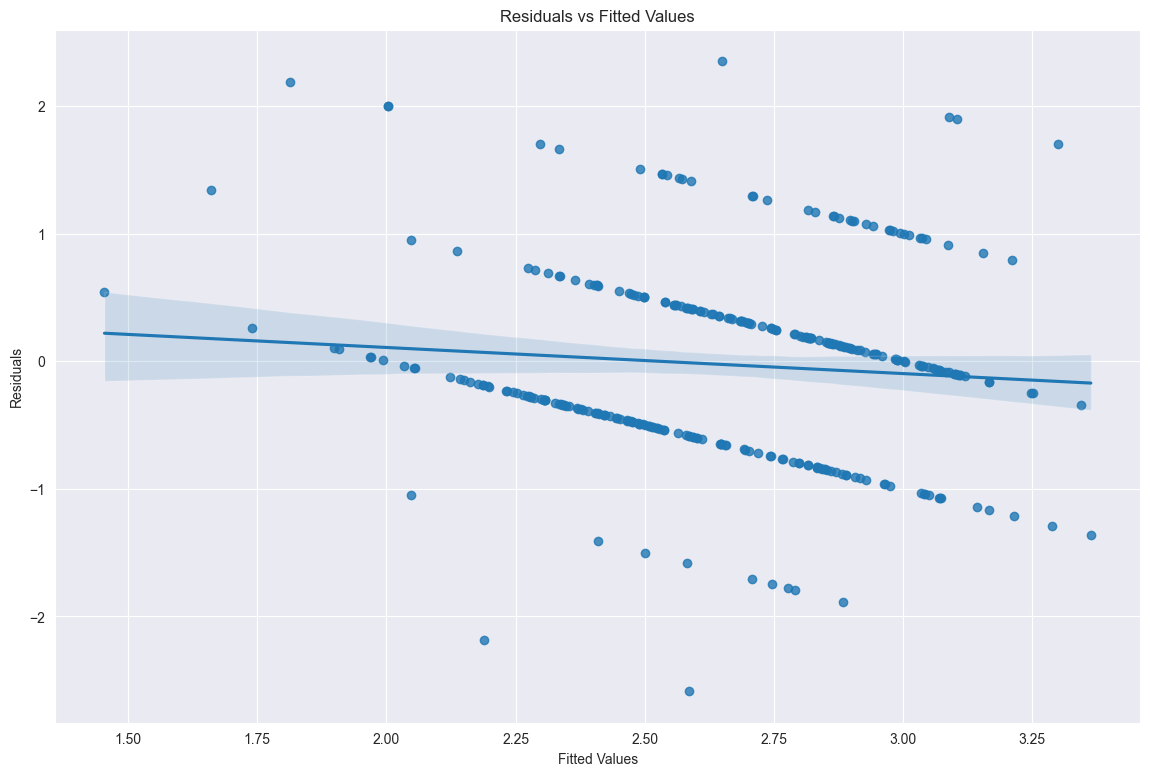

In [24]:
plt.figure(figsize = (14, 9))
sns.regplot(x=y_fitted, y=y_resid)
plt.xlabel('Fitted Values')
plt.ylabel('Residuals')
plt.title('Residuals vs Fitted Values')
plt.show()

We also see that while the residuals seem to be at least a bit less heteroskedastic, the best model still is quite poor in terms of interpretability and ability to explain the target variable. Seeing as regressional analysis has led us nowhere, what if we tried creating a multinomial logistic regression mode (aka a classification model) to better our odds of understanding the actual relationships between the independent & target variables.

In [25]:
logistic_models = pd.DataFrame()
for variable_set in all_choices:
    for j, variables in enumerate(variable_set):
        if j > 0:
            train, test = fn.setting_train_test_split(wines_data)
            model, test_x, test_y = fn.model_set_up([*variables], 'quality', train, test, True)
            fn.calculate_metrics(model, [*variables], logistic_models, logistic=True, test_x = test_x, test_y = test_y)

Testing logistic regression: quality ~ citric_acid
Optimization terminated successfully.
         Current function value: 1.154449
         Iterations 10
Testing logistic regression: quality ~ residual_sugar


Optimization terminated successfully.
         Current function value: 1.187748
         Iterations 8
Testing logistic regression: quality ~ chlorides
Optimization terminated successfully.
         Current function value: 1.177197
         Iterations 9
Testing logistic regression: quality ~ free_sulfur_dioxide
Optimization terminated successfully.
         Current function value: 1.179483
         Iterations 8
Testing logistic regression: quality ~ total_sulfur_dioxide
Optimization terminated successfully.
         Current function value: 1.184474
         Iterations 8
Testing logistic regression: quality ~ pH
Optimization terminated successfully.
         Current function value: 1.164845
         Iterations 8
Testing logistic regression: quality ~ sulphates
Optimization terminated successfully.
         Current function value: 1.180248
         Iterations 9
Testing logistic regression: quality ~ alcohol
Optimization terminated successfully.
         Current function value: 1.137364
  

For these classification models, we are going to use the F1 score for the judgement of the best logistic model out of the bunch created. This is because Accuracy represents how well the model was able to predict the True Positives & True Negative out of all classifications made. 

In [26]:
logistic_models.sort_values(by = ['Accuracy'], ascending=False, inplace=True)
best_logit_model = logistic_models.iloc[0]
best_logit_model_accuracy = best_logit_model.Accuracy
best_logit_model_variables = best_logit_model.Ind_Variables.split(',')
original_best_logit_model = best_logit_model_variables[:]

print(f"Best Logit Model Accuracy: {best_logit_model_accuracy}")

logistic_models.head()

Best Logit Model Accuracy: 0.61875


,Ind_Variables,Model,Accuracy,Precision,Recall,F1Score
"volatile_acidity,citric_acid,residual_sugar,total_sulfur_dioxide,pH,sulphates,alcohol","volatile_acidity,citric_acid,residual_sugar,to...",<statsmodels.discrete.discrete_model.MNLogit o...,0.618750,0.518232,0.618750,0.564043
"volatile_acidity,citric_acid,residual_sugar,pH,sulphates,alcohol","volatile_acidity,citric_acid,residual_sugar,pH...",<statsmodels.discrete.discrete_model.MNLogit o...,0.618750,0.518232,0.618750,0.564043
"volatile_acidity,citric_acid,total_sulfur_dioxide,pH,sulphates,alcohol","volatile_acidity,citric_acid,total_sulfur_diox...",<statsmodels.discrete.discrete_model.MNLogit o...,0.618750,0.518237,0.618750,0.564029
"volatile_acidity,citric_acid,residual_sugar,sulphates,alcohol","volatile_acidity,citric_acid,residual_sugar,su...",<statsmodels.discrete.discrete_model.MNLogit o...,0.612500,0.513329,0.612500,0.558462
"volatile_acidity,citric_acid,pH,sulphates,alcohol","volatile_acidity,citric_acid,pH,sulphates,alcohol",<statsmodels.discrete.discrete_model.MNLogit o...,0.609375,0.510417,0.609375,0.555476


Right off the bat, by only taking multivariate versions of logistic models we have found a combination of independent variables that are able to predict the quality of the wine almost `62%` of the time. If we take a look at other performance metrics, e.g. the `Precision` metric, which shows how many positives the model was able to predict correctly out of all positive predictions, we can see that `~51%` of the positive predictions we made were correct. Or if we take a look at `Recall` a metric that shows how out of all actual positives, how many of of those we were able to predict correctly, we can see that `~62%` of actual positives we got right.

All metrics tend to be showing that our top model is already pretty good at deducing the quality of a wine. Let's take a look at the the model results:

In [27]:
print(best_logit_model['Model'].fit().summary());

Optimization terminated successfully.
         Current function value: 1.062174
         Iterations 10


                          MNLogit Regression Results                          
Dep. Variable:                quality   No. Observations:                 1279
Model:                        MNLogit   Df Residuals:                     1239
Method:                           MLE   Df Model:                           35
Date:                Sun, 24 Mar 2024   Pseudo R-squ.:                  0.1069
Time:                        14:12:02   Log-Likelihood:                -1358.5
converged:                       True   LL-Null:                       -1521.1
Covariance Type:            nonrobust   LLR p-value:                 9.516e-49
           quality=1       coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept                3.5826      1.362      2.631      0.009       0.913       6.252
sulphates                0.4114      0.623      0.661      0.509      -0.809       1.632
citric_acid 

While the model does have a high accuracy, only several independent variables are deemed to be relevant for predicting the quality of a model based on the P-values we see for them (at a 5% significance level):
1. The `Intercepts` seem to be relevant at predicting each class and their difference with the `0` quality (remember, since we have made the `quality` metric a categorical variable, the first valeu - in this case 0 - becomes the base value for each of the other classes' predictions to be based off.). However, each value seems to be quite different.
2. The `citric acid` feature seems to be positively affecting the probability of the quality of the wine being `2` and not `1`. Although, the direct value is difficult to comprehend, because of the data being standardized, we can understand that with 1 standard deviation increase in the value of `citric_acid` you could expect the log-likelihood to jump around `2.93` standard deviations that the quality of the wine will be `2` instead of `0`. The same result can be seen for `quality=3`.
3. `alcohol` seems to have a positive effect on the wine being of quality 3 (out of 5), since the level of significance is `~0.023`. It seems as though 1 standard deviation increase in `alcohol` increases the log-likelihood of the quality of the win being 3 by more than 1.8 standard deviations.
4. `alcohol` seems to have the same effect on the log-likelihood of the quality of win being 5 (out of 5) as compared to `0` quality.

What would happen if we were to introduce polynomials and interaction terms into the best model? Our approach will be the same - identify the interaction term with the highest increase on Accuracy, add it to the model and then look for other interaction terms that increase the accuracy - up to 3 times. Again, our approach of ranking the models will not change - Accuracy will be the guiding compass.

In [28]:
interaction_term_space = [*combinations(possible_variable_space, 2)]
best_logit_model_instances = pd.DataFrame([best_logit_model])

for p in range(3):
    f1_improvements = {}

    if interaction_term_space is not None:

        for pv1, pv2 in interaction_term_space:

            interaction_term = f"{pv1}*{pv2}"
            ind_variables = best_logit_model_variables[:]
            
            ind_variables.append(pv1)
            ind_variables.append(pv2)
            ind_variables.append(interaction_term)

            train, test = fn.setting_train_test_split(wines_data)
            model, test_x, test_y = fn.model_set_up(set(ind_variables), 'quality', train, test, logistic = True)
            fn.calculate_metrics(model, set(ind_variables), best_logit_model_instances, logistic = True, test_x = test_x, test_y = test_y)

            test_x_const = sm.add_constant(test_x)
            pred_y = model.fit().predict(test_x_const).fillna(0)
            predictions = pred_y.idxmax(axis = 1)
            
            f1_improvement = accuracy_score(test_y, predictions) - best_logit_model_accuracy
        
            if f1_improvement > 0:
                f1_improvements[f'{interaction_term}'] = f1_improvement

    if len(f1_improvements):
        best_interaction_term = max(f1_improvements, key=f1_improvements.get)
        p1, p2 = best_interaction_term.split('*')
        interaction_term_space.remove((p1, p2))
        best_logit_model_variables.append(best_interaction_term)

Testing logistic regression: quality ~ sulphates + citric_acid + alcohol + residual_sugar + pH + volatile_acidity*citric_acid + total_sulfur_dioxide + volatile_acidity


Optimization terminated successfully.
         Current function value: 1.059782
         Iterations 10
Optimization terminated successfully.
         Current function value: 1.059782
         Iterations 10
Testing logistic regression: quality ~ sulphates + volatile_acidity*residual_sugar + citric_acid + alcohol + residual_sugar + pH + total_sulfur_dioxide + volatile_acidity
Optimization terminated successfully.
         Current function value: 1.059819
         Iterations 10
Optimization terminated successfully.
         Current function value: 1.059819
         Iterations 10
Testing logistic regression: quality ~ sulphates + citric_acid + alcohol + residual_sugar + pH + chlorides + volatile_acidity*chlorides + total_sulfur_dioxide + volatile_acidity
Optimization terminated successfully.
         Current function value: 1.036630
         Iterations 10
Optimization terminated successfully.
         Current function value: 1.036630
         Iterations 10
Testing logistic regression: qual

In [29]:
best_logit_model_instances.sort_values(by = ['Accuracy'], ascending=False, inplace=True)
best_logit_model_w_interaction_terms = best_logit_model_instances.iloc[0]
best_logit_model_accuracy_w_interaction_terms = best_logit_model_w_interaction_terms.Accuracy
best_logit_model_variables_w_interaction_terms = best_logit_model_w_interaction_terms.Ind_Variables.split(',')

print(f"Best Logit Model with interaction terms Accuracy: {best_logit_model_instances.iloc[0]['Accuracy']}")

best_logit_model_instances.head()

Best Logit Model with interaction terms Accuracy: 0.6375


,Ind_Variables,Model,Accuracy,Precision,Recall,F1Score
"sulphates,citric_acid,alcohol,residual_sugar,citric_acid*alcohol,total_sulfur_dioxide*sulphates,pH,total_sulfur_dioxide,volatile_acidity,residual_sugar*alcohol","sulphates,citric_acid,alcohol,residual_sugar,c...",<statsmodels.discrete.discrete_model.MNLogit o...,0.637500,0.594964,0.637500,0.591258
"sulphates,citric_acid,volatile_acidity*pH,alcohol,residual_sugar,citric_acid*alcohol,pH,total_sulfur_dioxide,volatile_acidity,residual_sugar*alcohol","sulphates,citric_acid,volatile_acidity*pH,alco...",<statsmodels.discrete.discrete_model.MNLogit o...,0.637500,0.576480,0.637500,0.587377
"sulphates,citric_acid,alcohol,residual_sugar,citric_acid*alcohol,pH,chlorides,total_sulfur_dioxide,volatile_acidity,residual_sugar*chlorides,residual_sugar*alcohol","sulphates,citric_acid,alcohol,residual_sugar,c...",<statsmodels.discrete.discrete_model.MNLogit o...,0.637500,0.592490,0.637500,0.599380
"sulphates,citric_acid,alcohol,residual_sugar,citric_acid*alcohol,pH,total_sulfur_dioxide,volatile_acidity,residual_sugar*alcohol","sulphates,citric_acid,alcohol,residual_sugar,c...",<statsmodels.discrete.discrete_model.MNLogit o...,0.634375,0.591386,0.634375,0.583916
"citric_acid*total_sulfur_dioxide,sulphates,citric_acid,alcohol,residual_sugar,citric_acid*alcohol,pH,total_sulfur_dioxide,volatile_acidity,residual_sugar*alcohol","citric_acid*total_sulfur_dioxide,sulphates,cit...",<statsmodels.discrete.discrete_model.MNLogit o...,0.634375,0.591362,0.634375,0.584053


The best performing logistic model becomes quite complex -it involves 3 interaction terms But it only increased the accuracy of the model by 2%, which is not really an improvement that is worth the while to create such complexity in the model. Thus, going forward we will be using the best logit model we made with linear variables only.

Since we now have our most accurate (and understandable) model, let's extract more robust values of the coefficients for each independent variable in the model for each `quality` class. We will do so using 10-Fold cross-validation of the train and test split and then average out the coefficients over the 10 separate models that were created on 10 train-test splits.

In [30]:
chosen_logistic_model =  pd.DataFrame([])
kf = KFold(10, shuffle = True, random_state = 2)

for i, (train_index, test_index) in enumerate(kf.split(wines_data)):
    print(f"Fold {i}:")
    train = wines_data.iloc[train_index]
    test = wines_data.iloc[test_index]

    model, test_x, test_y = fn.model_set_up(original_best_logit_model, 'quality', train, test, logistic = True)
    results = pd.DataFrame(model.fit().params)
    if i == 0:
        average_df = results
    average_df = (average_df + results) / 2

Fold 0:
Testing logistic regression: quality ~ sulphates + citric_acid + alcohol + residual_sugar + pH + total_sulfur_dioxide + volatile_acidity
Optimization terminated successfully.
         Current function value: 1.067537
         Iterations 10
Fold 1:
Testing logistic regression: quality ~ sulphates + citric_acid + alcohol + residual_sugar + pH + total_sulfur_dioxide + volatile_acidity


Optimization terminated successfully.
         Current function value: 1.059654
         Iterations 9
Fold 2:
Testing logistic regression: quality ~ sulphates + citric_acid + alcohol + residual_sugar + pH + total_sulfur_dioxide + volatile_acidity
Optimization terminated successfully.
         Current function value: 1.055456
         Iterations 9
Fold 3:
Testing logistic regression: quality ~ sulphates + citric_acid + alcohol + residual_sugar + pH + total_sulfur_dioxide + volatile_acidity
Optimization terminated successfully.
         Current function value: 1.067866
         Iterations 9
Fold 4:
Testing logistic regression: quality ~ sulphates + citric_acid + alcohol + residual_sugar + pH + total_sulfur_dioxide + volatile_acidity
Optimization terminated successfully.
         Current function value: 1.057274
         Iterations 9
Fold 5:
Testing logistic regression: quality ~ sulphates + citric_acid + alcohol + residual_sugar + pH + total_sulfur_dioxide + volatile_acidity
Optimization

Let's also rename the `Quality` classes to the original ones ranging from 3 to 8.

In [31]:
average_df = average_df.rename(columns = column_changes)
print("Averages of coefficients from 10-fold cross-validation")
average_df

Averages of coefficients from 10-fold cross-validation


,4,5,6,7,8
Intercept,2.571813,5.669354,5.590924,4.442787,1.729214
sulphates,0.548276,0.378433,-0.022892,0.293589,0.641795
citric_acid,0.991932,1.789509,1.045420,0.987923,1.239212
alcohol,-0.100090,0.864490,1.607494,1.262360,1.552661
residual_sugar,0.698573,0.609018,0.440370,0.670173,0.694158
pH,0.220554,-0.012908,-0.136844,0.199543,0.559801
total_sulfur_dioxide,-0.059679,-0.205984,-0.207858,-0.247277,-0.064558
volatile_acidity,-0.345752,0.219059,-0.267541,-0.179242,-0.044268


While making numerical sense out of the numbers might be difficult, we might have a good as to the directions of effects of each physicochemical feature on the quality of the wine comparing to the lowest quality wine in the dataset (with a quality of `3`):
1. All intercepts, except for the highest quality wines are very positive, which means that even if all the other independent variables were set to 0, the log-likelihood of the quality being higher than `3` is high. It's intereting though, how the value actually lower for the highest quality wines. 
2. For `volatile acidity` at each level of quality, the log-likelihood of the class being higher than the lowest class (`3`), is smaller. This means that `volatile acidity` seems to negatively affect the quality of the variable, which in some way makes sense due to its vinegar-y taste. But the negative value seems to decrease with each higher quality (maybe the vinegary taste is covered up by something else?)
3. As for `sulphates`, most random effects on likelihood of being part of higher classes when there are more sulphates in the wine. I guess it makes some sense because at least according to the description `sulphates` should not have much impact on the taste of the wine, but rather the color of the wine.
4. `pH` has very random effects on the probability of the class being higher than 3.
5. The opposite, however, is true for `total_sulfur_dioxide`, which tends to increase the log-likelihood of wine having higher `quality`, except for the highest quality wines. According to some quick Google-ing, higher concentrations of total sulfur dioxide can produce a `harsh, metallic and frequently bitter` taste. Free sulfur dioxide wine is a biproduct in the process of making wine.
6. `Citric acid` has a always a strong positive effect on the log-likelihood of a wine being higher in terms of queality. The effect peaks at quality 5 though. Perhaps this is because it has the most amount of data in the cohort?
7. `Residual sugar` has a somewhat stable positive impact on all quality of wines - and that is it's positive.
8. `Alcohol` only has positive effects on the quality of the wine. We also can see that the higher the grade to of the wine, the alcohol increase has more effect on the taste. 

Lastly, let's compare the accuracy of this model with what we had as the best linear model, which we calculated previously as the number of correctly predicted qualities by our best performing regression model (by way of rounding).

In [32]:
print(f"Multinomial regression accuracy: {linear_model_accuracy:.2f} %") 

Multinomial regression accuracy: 53.44 %


It's still less than what we got from the multivariate logistic model, which just goes to show in instances where there are small amounts of discrete classes, it's better to perform classification rather than regression.

## Conclusions

During this analysis we have tried to answer 2 main questions:
1. What makes a "Vinho Verde" wine exceptional in terms of quality?
2. Via a statistical model, what are the effects on quality from physicochemical features?

Our conclusions are:
- Exceptional Quality wines seem to have higher `fixed_acidity`, significantly lower `volatile_acidity`, higher `citric_acid`, higher `sulphate` concentration & more `alcohol`.
- Exceptional Wines seem to also have less variance in each of the physicochemical variable distributions.
- For the most part these are the relevant effect of each independent variable on the quality of the wine:
    - `Volatile acidity` negatively impacts the quality of the wine.
    - The amount of `sulphates` in the wine have a higher likelihood of pushing the wine to exceptional range or pull it out of the worst wine quality class - it's a bit of a wildcard feature.
    - `pH` only has stronger impact for already exceptional wines. The effect is positive.
    - `Total sulfur dioxide` has a negative impact towards the quality of the wine. Probably because it creates a harsh, bitter taste.
    - `Citric acid` has a positive effect on the quality of the wine that is stronger for the better wines.
    - `Residual sugar` has a positive effect on the quality of the wine. The measure itself refers to the amount of sugar left after fermentation, which migh mean that less sweet wines have higher chances of being rated better quality.
    - `Alcohol` - the higher the alcohol level, the better the quality is. And the effect seems to be stronger for better quality wines. 
- For target variables that have discrete values of up <10 distinct values, classification models perform much better in accuracy than regression models with polynomials and interaction terms included.


## Points of Improvement

- Using heteroskedasticity robust regression models.
- Transforming the quality metric into low/mid/high for a wider range of predictability (and thus clearer results distinctions between poor, medium and outstanding wines).
- Adding more sensory variables into the analysis (e.g. the texture, the smell).
- Implement regularization techniques to combat overfitting (which perhaps in the models I made was not the biggest problem). 